In [279]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import numpy as np

In [280]:
class Net(nn.Module): # con 20000 .. non toccare
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,1)

    def forward(self, x):

        layer1_out = torch.sigmoid(self.hidden_layer1(x))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out)  ## For regression, no activation is used in output layer
        return output
    
class Net1(nn.Module): # con 100000 
    def __init__(self):
        super(Net1, self).__init__()
        self.hidden_layer1 = nn.Linear(1,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.hidden_layer3 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,1)

    def forward(self, x):

        layer1_out = torch.sigmoid(self.hidden_layer1(x))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)  ## For regression, no activation is used in output layer
        return output

In [281]:
# Mass Spring 
num_iter = 100000
batch_size = 32
domain = (0.0, 60.0)
c = 4 # Damping constant
k = 2 # Stiffness of the spring
m = 20 # Mass
force = 5 # Forza

# f(t) = spostamento
# f^1(t) = velocità
# sappiamo che f(t) e f^1(t) partono dai punti 0 0
X_BOUNDARY = np.array([0.0])
F_BOUNDARY = np.array([0.0])

np.random.seed(0)


In [282]:
### Modello
net = Net1()
loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [283]:
# funzione che mi ritorna l'errore (un fit perfetto da sempre 0)
def f_interior(t, net):
    
    ft = net(t)
    dfdt = torch.autograd.grad(ft.sum(), t, create_graph=True)[0]
    d2fdt2 = torch.autograd.grad(dfdt.sum(), t, create_graph=True)[0]
    interior = force - c * dfdt - k * ft - m *  d2fdt2
    return interior

In [284]:
### (3) Training / Fitting

loss_evolution = []
for epoch in range(num_iter):
    
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    x_boundary = Variable(torch.from_numpy(X_BOUNDARY).float(), requires_grad=True).reshape(X_BOUNDARY.size,1)
    f_boundary = Variable(torch.from_numpy(F_BOUNDARY).float(), requires_grad=True).reshape(X_BOUNDARY.size,1)

    ft_ris = net(x_boundary)
    dfdt_ris = torch.autograd.grad(ft_ris.sum(), x_boundary, create_graph=True)[0]


    loss_bound_cond = loss_function(ft_ris,f_boundary) + loss_function(dfdt_ris, f_boundary)
    
    # Loss based on interior
    t_collocation = np.random.uniform(domain[0], domain[1], size=(batch_size,1))
    np.random.shuffle(t_collocation)
    
    all_zeros = np.zeros((batch_size,1))
    
    t = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
    
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = f_interior(t, net) # output of f(x)
    mse_f = loss_function(f_out, pt_all_zeros) 

    
    # Combining the loss functions
    loss = mse_f + loss_bound_cond
    loss_evolution.append(float(loss))
    
    
    loss.backward() # computing gradients using backward propagation
    optimizer.step() # aggiorno valori

    with torch.autograd.no_grad():
        if epoch % 1000 == 0:
    	    print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(23.9495)
1000 Traning Loss: tensor(0.1638)
2000 Traning Loss: tensor(0.0564)
3000 Traning Loss: tensor(0.1250)
4000 Traning Loss: tensor(0.0671)
5000 Traning Loss: tensor(0.0416)
6000 Traning Loss: tensor(0.0378)
7000 Traning Loss: tensor(0.0457)
8000 Traning Loss: tensor(0.0479)
9000 Traning Loss: tensor(0.0397)
10000 Traning Loss: tensor(0.0620)
11000 Traning Loss: tensor(0.0648)
12000 Traning Loss: tensor(0.0542)
13000 Traning Loss: tensor(0.0226)
14000 Traning Loss: tensor(0.0251)
15000 Traning Loss: tensor(0.0319)
16000 Traning Loss: tensor(0.0234)
17000 Traning Loss: tensor(0.0120)
18000 Traning Loss: tensor(0.0250)
19000 Traning Loss: tensor(0.0303)
20000 Traning Loss: tensor(0.0182)
21000 Traning Loss: tensor(0.0187)
22000 Traning Loss: tensor(0.0098)
23000 Traning Loss: tensor(0.0111)
24000 Traning Loss: tensor(0.0111)
25000 Traning Loss: tensor(0.0192)
26000 Traning Loss: tensor(0.0144)
27000 Traning Loss: tensor(0.0130)
28000 Traning Loss: tensor(0.013

In [285]:
# per avere un confronto 
def mydiff(x, t):
    dx1dt = x[1]
    dx2dt = (force - c*x[1] - k*x[0])/m
    dxdt = [dx1dt, dx2dt]
    return dxdt

In [286]:
############ preparo i dati da plottare #################

num_points = 100
step = (domain[1] - domain[0]) / num_points
t_collocation = np.arange(domain[0], domain[1], step, dtype=float)
t_col_reshaped = t_collocation.reshape(num_points,1)

# in net
t = Variable(torch.from_numpy(t_col_reshaped).float(), requires_grad=True)

# out net
f_out = net(t)
dfdt_out = torch.autograd.grad(f_out.sum(), t, create_graph=True)[0]

#ODE SOlver.. al posto della soluzione analitica
x_init = [X_BOUNDARY[0],F_BOUNDARY[0]]
x = odeint(mydiff, x_init, t_collocation)
x1 = x[:,0]  #position
x2 = x[:,1]  #velocity/speed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


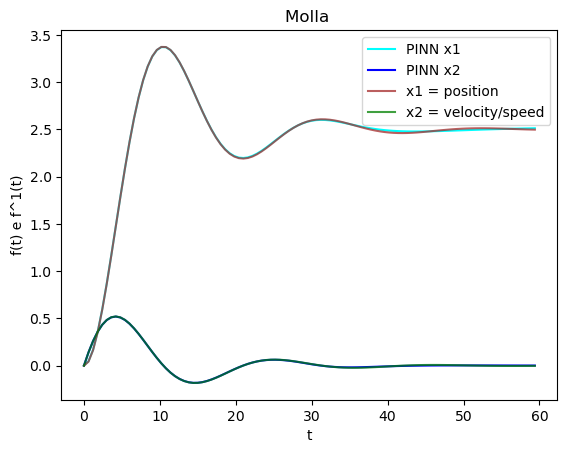

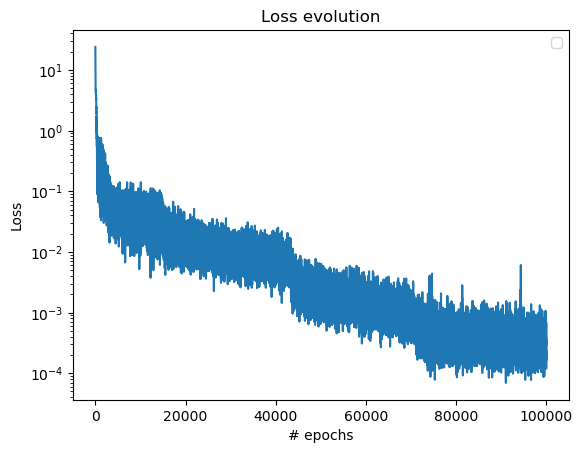

In [287]:

######### PLOTTO #################

fig, ax = plt.subplots()
ax.plot(t_collocation, 
        f_out.detach().numpy(), 
        label="PINN x1", 
        color="cyan"
        )
ax.plot(t_collocation, 
        dfdt_out.detach().numpy(), 
        label="PINN x2", 
        color = "blue"
        )
ax.plot(
        t_collocation,
        x1,
        label=f"x1 = position",
        color="brown",
        alpha=0.75,
)
ax.plot(
        t_collocation,
        x2,
        label=f"x2 = velocity/speed",
        color="green",
        alpha=0.75,
)

ax.set(title="Molla ", xlabel="t", ylabel="f(t) e f^1(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()